In [11]:
import os
import sys

# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join('..')))

import torch
import numpy as np
from torch import nn
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from data import DatasetEEG, DatasetEEGTorch
from data.preprocessing import normalize_signals, crop_signals
from helpers.model_utils import plot_training_metrics, count_model_parameters, train_model


In questo esempio confronto i modelli per l'encoding dei segnali. Poi la classificazione viene effettuata a partire dai vettori encoded.

Preparo i dataset

In [4]:
# Carico i dataset per il training e il test
dataset_bci = DatasetEEG.load('../dataset_bci/processed/include_rejected/01_Training.dataset')
dataset_bci_test = DatasetEEG.load('../dataset_bci/processed/include_rejected/01_Test.dataset')

# Li normalizzo e croppo
normalize_signals(dataset_bci)
normalize_signals(dataset_bci_test)

crop_signals(dataset_bci, t_min=0.5, t_max=2.5)
crop_signals(dataset_bci_test, t_min=0.5, t_max=2.5)

# Mostro le caratteristiche dei due dataset
print(dataset_bci)
print(dataset_bci_test)

# Altre caratteristiche dei dati che serviranno successivamente
fs = 250
channels = 22
num_timepoints = dataset_bci.num_timepoints


num_trials               :  288
num_channels             :  22
num_timepoints           :  500
labels_type              :  single_label
labels_format            :  int
subject                  :  1
fs                       :  250

num_trials               :  288
num_channels             :  22
num_timepoints           :  500
labels_type              :  single_label
labels_format            :  int
subject                  :  1
fs                       :  250



In [5]:
dataset_training, dataset_validation = dataset_bci.split_dataset(validation_size=0.2)

print(dataset_training)
print(dataset_validation)

dataset_training_pytorch = DatasetEEGTorch(dataset_training)
dataset_validation_pytorch = DatasetEEGTorch(dataset_validation)
dataset_test_pytorch = DatasetEEGTorch(dataset_bci_test)

num_trials               :  230
num_channels             :  22
num_timepoints           :  500
labels_type              :  single_label
labels_format            :  int
subject                  :  1
fs                       :  250

num_trials               :  58
num_channels             :  22
num_timepoints           :  500
labels_type              :  single_label
labels_format            :  int
subject                  :  1
fs                       :  250



In [6]:
# Se è presente la GPU sfrutto quella e sposto i dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

dataset_training_pytorch.to_device(device)
dataset_validation_pytorch.to_device(device)
dataset_test_pytorch.to_device(device)


cuda


/home/nuzzi/Projects/EEG_Pipeline/EEG-ANN-Pipeline/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [9]:
# Creo i dataloader
batch_size = 32
dataloader_training = DataLoader(dataset_training_pytorch, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(dataset_validation_pytorch, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(dataset_test_pytorch, batch_size=batch_size, shuffle=False)

## VAE Customizzabile
Il primo modello è una VAE che può essere customizzata fornendo un encoder e un decoder. 
Per l'encoder uso EEGNet, mentre per il decoder bisogna invertire accuratamente i livelli (convoluzioni trasposte al posto delle convoluzioni, upsampling al posto di avgpool) e alla fine viene inserito un ulteriore livello Conv2d per correggere la dimensione dell'output e riportarla allo stesso numero di punti temporali. Inoltre è importante sapere la dimensione dei tensori poco prima del livello latente, in quanto questa è il punto di partenza per costruire il primo livello del decoder. Per facilitare il compito genere un tensore dummy di dimensione nota e lo uso per vedere la dimensione del vettore poco prima che venga encoded.

In [12]:
from models import VAE
from models.layers import Conv2dMaxNorm

latent_dim = 1024
F1, F2 = 16, 32

# Encoder uguale a EEGNet
encoder = nn.Sequential(
        nn.Conv2d(1, F1, kernel_size=(1, 128), padding='same', bias=False), # First temporal convolution
        nn.BatchNorm2d(F1),
        Conv2dMaxNorm(F1, F2, kernel_size=(channels, 1), bias=False, groups=F1, max_norm_val=1), # Depthwise convolution
        nn.BatchNorm2d(F2),
        nn.ELU(),
        nn.AvgPool2d(kernel_size=(1,4)),
        nn.Dropout(0.5),
        nn.Conv2d(F2, F2, kernel_size=(1, 16), bias=False, groups=F2),  # Separable = Depthwise + Pointwise
        nn.Conv2d(F2, F2, kernel_size=(1, 1), bias=False),              # Separable = Depthwise + Pointwise
        nn.BatchNorm2d(F2),
        nn.ELU(),
        nn.AvgPool2d(kernel_size=(1,8)),
        nn.Dropout(0.5),
)
    
dummy_input, _ = dataset_training_pytorch[0:1]
dummy_input = dummy_input.cpu()

# Applico l'encoder e vedo la dimensione dei tensori poco prima del livello latente
dummy_encoded = encoder(dummy_input)
print(dummy_encoded.shape)


decoder = nn.Sequential(
        nn.Linear(latent_dim, 13 * 32),
        nn.Unflatten(1, (32, 1, 13)), 
        # Upsampling
        nn.Upsample(scale_factor=(1,8), mode='bilinear'),
        # Convoluzione temporale finale depthwise separable
        nn.ConvTranspose2d(F2, F2, kernel_size=(1, 16), bias=False, groups=F2),  # Separable = Depthwise + Pointwise
        nn.ConvTranspose2d(F2, F2, kernel_size=(1, 1), bias=False),              # Separable = Depthwise + Pointwise
        nn.BatchNorm2d(F2),
        nn.ELU(),
        nn.Dropout(0.5),
        # Upsampling
        nn.Upsample(scale_factor=(1,4), mode='bilinear'),
        # Convoluzione canali
        nn.ConvTranspose2d(F2, F2, kernel_size=(channels, 1), bias=False, groups=F2), # Depthwise convolution
        nn.BatchNorm2d(F2),
        nn.ELU(),
        nn.Dropout(0.5),
        # Ultima convoluzione temporale
        nn.ConvTranspose2d(F2, 1, kernel_size=(1, 128), padding=(0,64), bias=False), # First temporal convolution
        # Convoluzione per correggere la dimensione
        nn.ConvTranspose2d(1, 1, kernel_size=(1, 26), bias=False), # First temporal convolution
        )

# Prendo un vettore di "z" vuoto e lo passo attraverso il decoder
dummy_z = torch.zeros((1, latent_dim))
dummy_decoded = decoder(dummy_z)
print(dummy_decoded.shape)

# Creo il modello VAE
model = VAE(encoder, decoder, latent_dim)
model.to(device)
print(f'Il modello ha {count_model_parameters(model)} parametri')


torch.Size([1, 32, 1, 13])
torch.Size([1, 1, 22, 500])
Il modello ha 437338 parametri


/home/nuzzi/Projects/EEG_Pipeline/EEG-ANN-Pipeline/.venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(input, weight, bias, self.stride,


 11%|█▏        | 57/500 [00:07<00:50,  8.81it/s, reconstruction_loss=0.488, kl_loss=0.0349, loss=0.523]

100%|██████████| 500/500 [00:58<00:00,  8.48it/s, reconstruction_loss=0.43, kl_loss=0.0413, loss=0.471] 


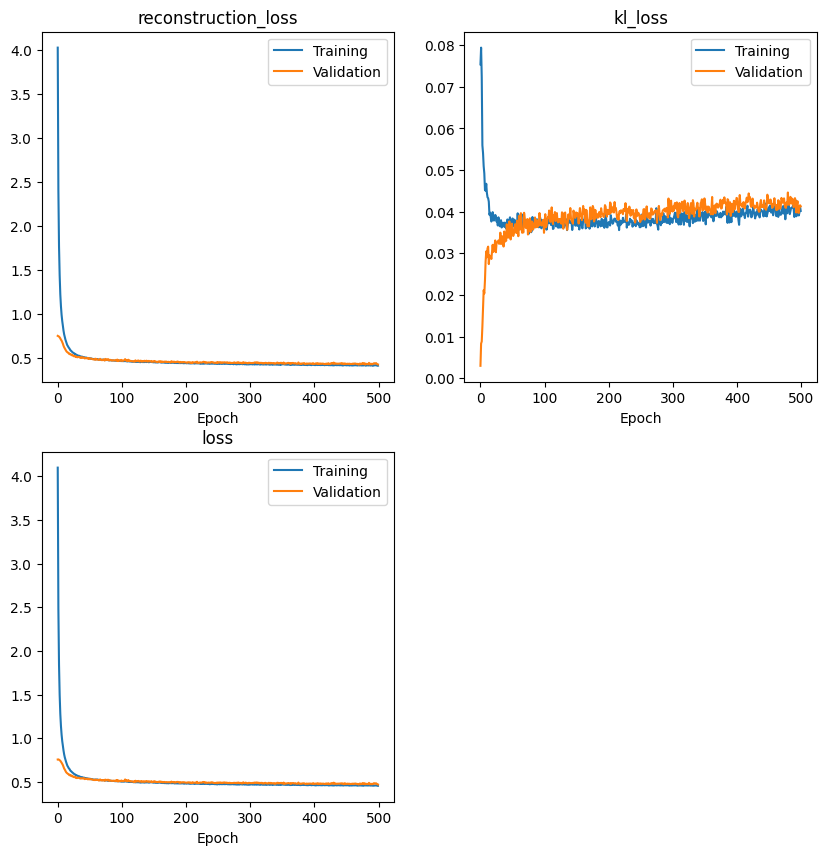

In [13]:
# Ottimizzatore
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Faccio il training e ottengo la storia di tutte le metriche
metrics = train_model(model, optimizer, dataloader_training,
                      dataloader_validation=dataloader_validation, epochs=500)

# Plot risultati del training
plot_training_metrics(metrics)

Visualizzo la bontà della ricostruzione dei segnali su uno dei trial di training

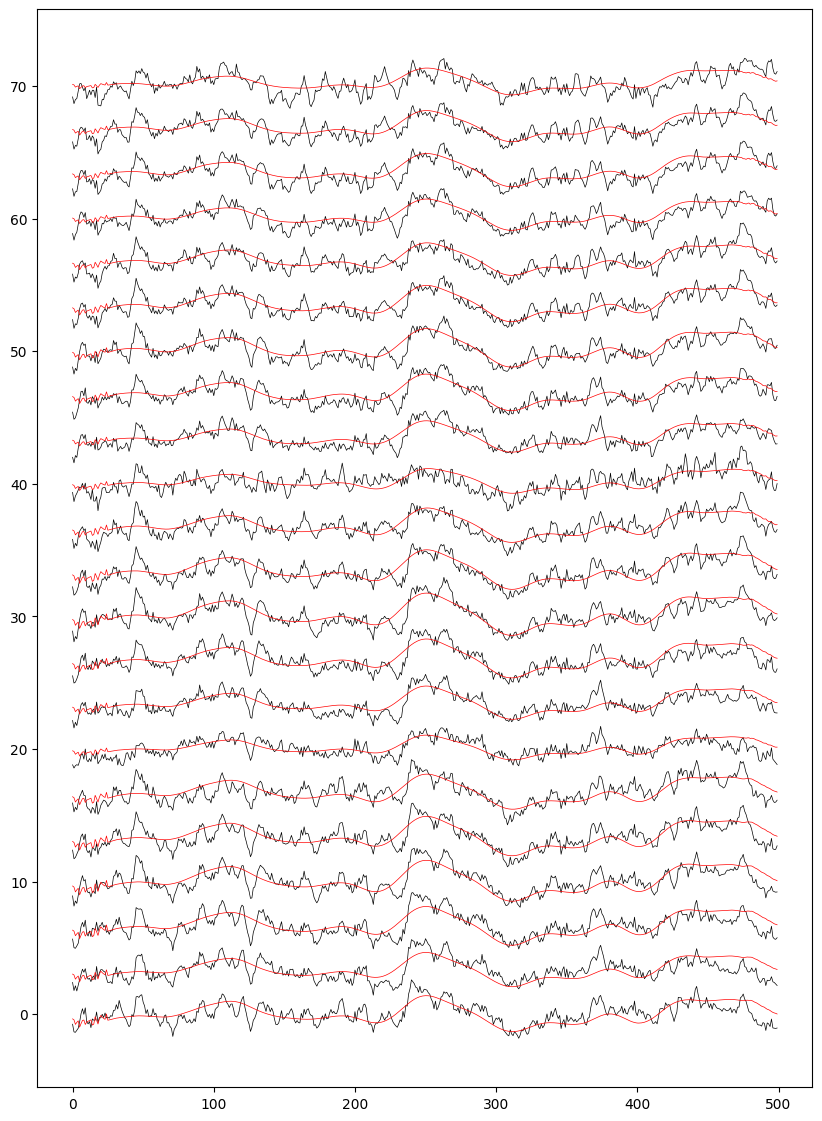

In [14]:
# Prendo il trial 0 e lo passo nella VAE per ottenerne la ricostruzione
x, _ = dataset_training_pytorch[0]
trial_train = x.view(1, 1, 22, num_timepoints).to(device)
decoded, _, _ = model(trial_train)

# Visualizzo tutti i canali uno sotto l'altro
std = torch.std(trial_train)

plt.figure(figsize=(10,14))
for i in range(channels):

    y_shift = 4 * std * i

    plt.plot(trial_train[0,0,i,:].cpu() + y_shift.cpu(), color='k', linewidth=0.5)
    plt.plot(decoded[0,0,i,:].detach().cpu() + y_shift.cpu(), color='r', linewidth=0.5)



Per valutare l'accuratezza fitto un Support Vector Classifier (SVC) sulle rappresentazioni encoded della rete nel training set e poi testo il classificatore sul test set. Notare che a ogni esecuzione il risultato è diverso, poiché le rappresentazioni latenti "z" vengono samplate casualmente. Per ottenere un risultato stabile è possibile sostituire "z" con il vettore delle medie delle gaussiane "mu"

In [15]:
model.eval()

# Training set
encoded_train = np.zeros((0, latent_dim))
labels_train = np.zeros(0)

for batch in dataloader_training:

    x, label =  batch

    _, mu, logvar = model.forward(x)
    z = model.reparameterize(mu, logvar)

    encoded_train = np.concatenate((encoded_train, z.cpu().detach().numpy()), axis=0)
    labels_train = np.concatenate((labels_train, label.cpu().detach().numpy()))

# Test set
encoded_test = np.zeros((0, latent_dim))
labels_test  = np.zeros(0)

for batch in dataloader_test:

    x, label =  batch

    _, mu, logvar = model.forward(x)
    z = model.reparameterize(mu, logvar)

    encoded_test = np.concatenate((encoded_test, z.cpu().detach().numpy()), axis=0)
    labels_test = np.concatenate((labels_test, label.cpu().detach().numpy()))

# Inizializzo il modello SVC
from sklearn.svm import SVC

model_svc = SVC()

# Fit del modello e calcolo accuratezza
model_svc.fit(encoded_train, labels_train)
accuracy = model_svc.score(encoded_train, labels_train)

print(f'Training accuracy = {accuracy*100:.2f}%')

# Ripeto sul testing set
accuracy = model_svc.score(encoded_test, labels_test)

print(f'Test accuracy = {accuracy*100:.2f}%')


Training accuracy = 100.00%
Test accuracy = 28.82%


## VAE + Classificatore
Per fornire una guida allo costruzione dello spazio latente che tenga conto delle label assegnate unisco la VAE a un classificatore. Quest'ultimo prende in input le rappresentazioni latenti "z" e cerca di prevedere la label, in modo da spingere la VAE ad apprendere rappresentazioni più significative per il compito di classificazione

In [16]:
from models import VAEClassifier
from models.layers import Conv2dMaxNorm

latent_dim = 128
filters = 32

encoder = nn.Sequential(
        Conv2dMaxNorm(1, filters, kernel_size=(1, 13)),
        Conv2dMaxNorm(filters, filters, kernel_size=(channels, 1), bias=False),
        nn.BatchNorm2d(filters),
        nn.MaxPool2d(kernel_size=(1, 35), stride=(1, 7)),
        nn.Dropout(0.5)
)

decoder = nn.Sequential(
        nn.Linear(latent_dim, 65 * 32),
        nn.Unflatten(1, (32, 1, 65)), 
        nn.ConvTranspose2d(filters, filters, kernel_size=(1, 13)),
        nn.ConvTranspose2d(filters, filters, kernel_size=(channels, 1), bias=False),
        nn.BatchNorm2d(filters),
        nn.ConvTranspose2d(filters, 1, kernel_size=(1, 44), stride=(1, 6)),
        nn.Dropout(0.5)
)

classifier = nn.Sequential(
        nn.Linear(latent_dim, 32),
        nn.ELU(),
        nn.Dropout(0.7),
        nn.Linear(32, 4)
)

# Creo il modello VAE
model = VAEClassifier(encoder, decoder, classifier, latent_dim, num_classes=4)
model.to(device)
print(f'Il modello ha {count_model_parameters(model)} parametri')


Il modello ha 332965 parametri


100%|██████████| 500/500 [01:01<00:00,  8.15it/s, reconstruction_loss=0.608, kl_loss=0.147, classifier_loss=1.21, loss=1.97] 


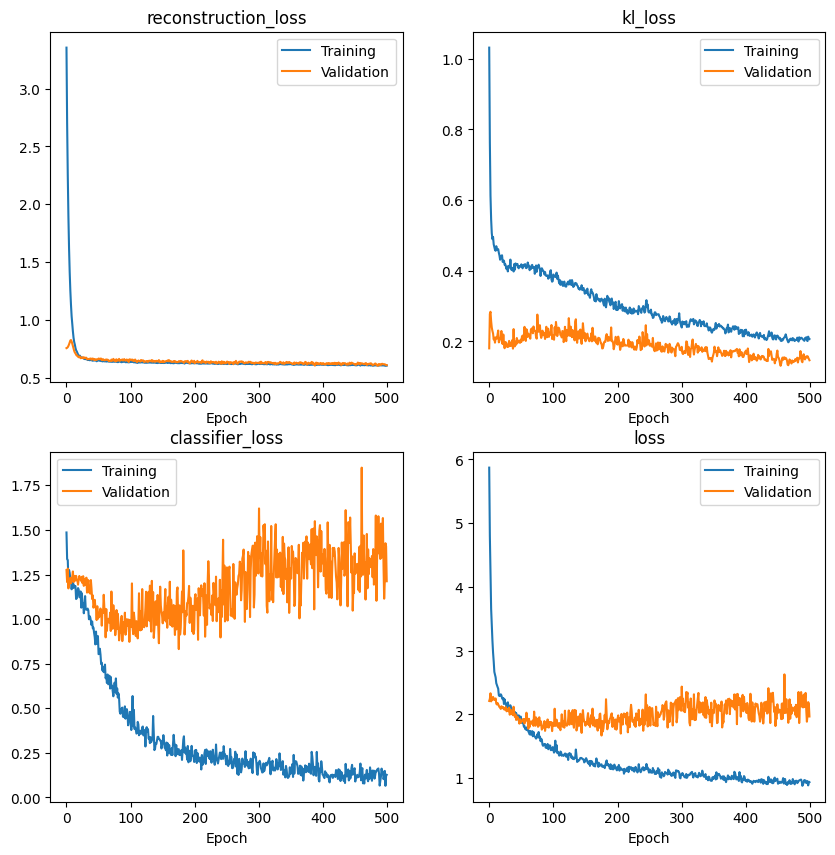

In [17]:
# Ottimizzatore
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Faccio il training e ottengo la storia di tutte le metriche
metrics = train_model(model, optimizer, dataloader_training,
                      dataloader_validation=dataloader_validation, epochs=500)

# Plot risultati del training
plot_training_metrics(metrics)

Testo il modello sul test set

In [18]:
# Setto il modello in modalità eval (non training)
model.eval()

# Inizializzo per accumulare poi in ogni batch
accuracy = 0

# Ciclo sul test set
for i, batch in enumerate(dataloader_test):

    x, y = batch
    y_pred = model.predict(x)

    # Calcolo l'accuratezza
    accuracy += torch.sum(y_pred == y).item()

accuracy /= len(dataloader_test.dataset)

print(f'Accuratezza sul test set = {accuracy:.4f}')


Accuratezza sul test set = 0.5938


Confronto il risultato del classificatore con quello di una SVC addestrata sulle rappresentazioni latenti, per controllare che l'aggiunta del classificatore le abbia modificate rispetto al caso precedente

In [19]:
# Training set
encoded_train = np.zeros((0, latent_dim))
labels_train = np.zeros(0)

for batch in dataloader_training:

    x, label =  batch

    _, mu, logvar, _ = model.forward(x)
    z = model.reparameterize(mu, logvar)

    encoded_train = np.concatenate((encoded_train, z.cpu().detach().numpy()), axis=0)
    labels_train = np.concatenate((labels_train, label.cpu().detach().numpy()))

# Test set
encoded_test = np.zeros((0, latent_dim))
labels_test  = np.zeros(0)

for batch in dataloader_test:

    x, label =  batch

    _, mu, logvar, _ = model.forward(x)
    z = model.reparameterize(mu, logvar)

    encoded_test = np.concatenate((encoded_test, z.cpu().detach().numpy()), axis=0)
    labels_test = np.concatenate((labels_test, label.cpu().detach().numpy()))

# Inizializzo il modello SVC
from sklearn.svm import SVC

model_svc = SVC()

# Fit del modello e calcolo accuratezza
model_svc.fit(encoded_train, labels_train)
accuracy = model_svc.score(encoded_train, labels_train)

print(f'Training accuracy = {accuracy*100:.2f}%')

# Ripeto sul testing set
accuracy = model_svc.score(encoded_test, labels_test)

print(f'Test accuracy = {accuracy*100:.2f}%')


Training accuracy = 100.00%
Test accuracy = 57.64%
